## Execution of different models against the tabfact dataset:

https://github.com/huggingface/transformers/tree/main/examples/research_projects/tapex

Imports

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, accuracy_score
from matplotlib import rcParams
from tqdm.notebook import tqdm
import pickle


### Choose Execution Style:

In [2]:
RUN_SCRIPT = False # Set to True to run the script, False to use the adjusted scripts for executing the code in the notebook

In [3]:
this_dir = os.getcwd()
base_path = os.path.join('original_repo', 'code')

if RUN_SCRIPT:
    os.chdir(base_path)
else:
    current_dir = os.getcwd()
    target_dir = os.path.join(current_dir, base_path)
    os.chdir(target_dir)

print("Current working directory:", os.getcwd())

Current working directory: /users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/original_repo/code


### Plotting functionality:

In [27]:
def plot_confusion_matrix(
    all_labels, 
    pred_labels, 
    title="Confusion Matrix", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots a confusion matrix using Seaborn heatmap.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    pred_labels : list or array
        Predicted labels (0/1).
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    cm = confusion_matrix(all_labels, pred_labels)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=['Pred 0', 'Pred 1'],
        yticklabels=['True 0', 'True 1']
    )
    plt.title(title, fontsize=14, weight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_roc_curve(
    all_labels, 
    all_probs, 
    title="Receiver Operating Characteristic", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots the ROC curve with AUC value.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    all_probs : list or array
        Predicted probabilities for the positive class.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.plot(
        fpr, tpr, color='darkorange', lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_multi_roc_curves(
    models_data, 
    title="ROC Comparison", 
    figsize=(3.5, 2),  # Smaller size for 0.5 linewidth
    font="Times New Roman", 
    save_path=None
):
    """
    Plots ROC curves for multiple models on the same plot, optimized for scientific reports.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "labels": list of true labels (0/1),
              "probs": list of predicted probabilities for label=1
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    # Set font globally
    rcParams['font.family'] = font
    rcParams['font.size'] = 10  # Consistent font size for readability

    plt.figure(figsize=figsize)

    # Plot ROC curves for each model
    for model_info in models_data:
        name = model_info["name"]
        labels = model_info["labels"]
        probs = model_info["probs"]

        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr, tpr, lw=1.5, label=f'{name} (AUC = {roc_auc:.2f})'
        )

    # Plot the diagonal
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label="Random Classifier")

    # Set limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10, labelpad=5)
    plt.ylabel('True Positive Rate', fontsize=10, labelpad=5)

    # Title and legend
    # plt.title(title, fontsize=10, weight='bold', pad=10)
    plt.legend(loc="lower right", fontsize=8, frameon=False)

    # Grid and layout for clean presentation
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_precision_recall_curve(
    all_labels, 
    all_probs, 
    title="Precision-Recall Curve", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots the Precision-Recall curve with Average Precision (AP) score.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    all_probs : list or array
        Predicted probabilities for the positive class.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.plot(
        recall, precision, color='darkorange', lw=2, 
        label=f'AP = {avg_precision:.2f}'
    )
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()


def plot_multi_pr_curves(
    models_data, 
    title="Precision-Recall Comparison", 
    figsize=(3.5, 2),  # Smaller size for 0.5 linewidth
    font="Times New Roman", 
    save_path=None
):
    """
    Plots Precision-Recall curves for multiple models on the same plot, optimized for scientific reports.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "labels": list of true labels (0/1),
              "probs": list of predicted probabilities for label=1
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    # Set font globally
    rcParams['font.family'] = font
    rcParams['font.size'] = 10  # Consistent font size for readability

    plt.figure(figsize=figsize)

    # Plot Precision-Recall curves for each model
    for model_info in models_data:
        name = model_info["name"]
        labels = model_info["labels"]
        probs = model_info["probs"]

        precision, recall, _ = precision_recall_curve(labels, probs)
        avg_precision = average_precision_score(labels, probs)

        plt.plot(
            recall, precision, lw=1.5,
            label=f'{name} (AP = {avg_precision:.2f})'
        )

    # Set labels and limits
    plt.xlabel('Recall', fontsize=10, labelpad=5)
    plt.ylabel('Precision', fontsize=10, labelpad=5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Title and legend
    # plt.title(title, fontsize=10, weight='bold', pad=10)
    plt.legend(
        loc="lower left", fontsize=8, frameon=False, 
        ncol=1 # if len(models_data) == 1 else 2
    )

    # Grid and layout for clean presentation
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_probability_distribution(
    all_probs, 
    title="Probability Distribution", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots the distribution of predicted probabilities.

    Parameters:
    -----------
    all_probs : list or array
        Predicted probabilities for the positive class.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.hist(
        all_probs, bins=20, color='darkorange', 
        edgecolor='black', alpha=0.7
    )
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_multi_probability_distributions(
    models_data, 
    title="Probability Distributions", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Overlaid histogram of predicted probabilities for multiple models.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "probs": list of predicted probabilities
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    bins = np.linspace(0, 1, 20)
    for model_info in models_data:
        name = model_info["name"]
        probs = model_info["probs"]
        plt.hist(
            probs, bins=bins, alpha=0.5, 
            edgecolor='black', label=name
        )

    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()


def plot_multi_probability_distributions_percent(
    models_data, 
    title="Probability Distributions (Percent)", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Overlaid histogram of predicted probabilities in percentage terms for multiple models.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "probs": list of predicted probabilities
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    bins = np.linspace(0, 1, 20)
    for model_info in models_data:
        name = model_info["name"]
        probs = model_info["probs"]
        # Calculate weights to represent percentages
        weights = np.ones_like(probs) * 100.0 / len(probs)
        plt.hist(
            probs, bins=bins, alpha=0.5, 
            edgecolor='black', label=name, weights=weights
        )

    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_threshold_metrics(
    all_labels, 
    all_probs, 
    thresholds=None, 
    font="Times New Roman", 
    title="Threshold vs Metrics", 
    figsize=(8, 6), 
    save_path=None
):
    """
    Plots precision, recall, F1-score, and accuracy as functions of the decision threshold.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    all_probs : list or array
        Predicted probabilities for the positive class.
    thresholds : list or array, optional
        Threshold values to evaluate. Defaults to np.linspace(0, 1, 100).
    font : str
        Font family to use.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)
        
    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []

    for thresh in thresholds:
        preds = [1 if p > thresh else 0 for p in all_probs]
        # Calculate metrics
        precisions.append(precision_score(all_labels, preds, zero_division=0))
        recalls.append(recall_score(all_labels, preds, zero_division=0))
        f1_scores.append(f1_score(all_labels, preds, zero_division=0))
        accuracies.append(accuracy_score(all_labels, preds))
    
    # Set font globally
    rcParams['font.family'] = font
    
    # Plot metrics
    plt.figure(figsize=figsize)
    plt.plot(thresholds, precisions, label='Precision', lw=2)
    plt.plot(thresholds, recalls, label='Recall', lw=2)
    plt.plot(thresholds, f1_scores, label='F1-Score', lw=2)
    plt.plot(thresholds, accuracies, label='Accuracy', lw=2, linestyle='--', color='gray')
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()


def plot_multi_threshold_metrics(
    models_data, 
    thresholds=None, 
    title="Threshold vs Metrics", 
    font="Times New Roman", 
    figsize=(10, 8), 
    save_path=None
):
    """
    Plots precision, recall, F1-score, and accuracy vs threshold for each model in the same figure.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "labels": list of true labels (0/1),
              "probs": list of predicted probabilities for label=1
            }
    thresholds : list or array, optional
        Threshold values to evaluate. Defaults to np.linspace(0, 1, 100).
    title : str
        Title of the plot.
    font : str
        Font family to use.
    figsize : tuple
        Size of the figure in inches.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)

    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    for model_info in models_data:
        name = model_info["name"]
        labels = model_info["labels"]
        probs = model_info["probs"]

        precisions = []
        recalls = []
        f1_scores = []
        accuracies = []

        for thresh in tqdm(thresholds):
            preds = [1 if p > thresh else 0 for p in probs]
            # Calculate metrics
            precisions.append(precision_score(labels, preds, zero_division=0))
            recalls.append(recall_score(labels, preds, zero_division=0))
            f1_scores.append(f1_score(labels, preds, zero_division=0))
            accuracies.append(accuracy_score(labels, preds))

        # Plot metrics
        plt.plot(
            thresholds, f1_scores, label=f'{name} F1-Score', lw=2
        )
        plt.plot(
            thresholds, precisions, label=f'{name} Precision', lw=1, linestyle='--'
        )
        plt.plot(
            thresholds, recalls, label=f'{name} Recall', lw=1, linestyle=':'
        )
        plt.plot(
            thresholds, accuracies, label=f'{name} Accuracy', lw=1.5, linestyle='-.'
        )

    # Add axis labels, title, and legend
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontsize=16, weight='bold')
    plt.legend(
        loc="best", fontsize=10, frameon=False, 
        ncol=2 if len(models_data) > 1 else 1  # Adjust legend layout for multiple models
    )
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

### Execution of the lpa model

In [5]:
# !sh get_data.sh # to be run only once in the beginning

In [6]:
if RUN_SCRIPT:
    !python model.py --do_test --resume

In [7]:
if not RUN_SCRIPT:
    import model_adjusted as lpa_model

    args = {
        'do_train': False,
        'do_val': False,
        'do_test': True,
        'do_simple_test': False,
        'do_complex_test': False,
        'do_small_test': False,
        'emb_dim': 128,
        'dropout': 0.2,
        'resume': True,
        'batch_size': 512,
        'data_dir': '../preprocessed_data_program/',
        'max_seq_length': 100,
        'layer_num': 3,
        'voting': False,
        'id': "0",
        'analyze': False,
        'threshold': 0.5,
        'output_dir': 'checkpoints/',
        'learning_rate': 5e-4
    }


    lpa_results = lpa_model.run_experiment(args)

    if lpa_results is not None:
        save_path = os.path.join(this_dir, 'plots', 'lpa')
        os.makedirs(save_path, exist_ok=True)
        
        pickle_path = os.path.join(save_path, "lpa_results.pkl")
        with open(pickle_path, 'wb') as f:
            pickle.dump(lpa_results, f)

Loading used 1.808530330657959 secs


/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/original_repo/code/model_adjusted.py:314: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_stat.l

Reloading saved model from checkpoints/
TP: 40204, FP: 22856, FN: 36444, TN: 33814. precision = 0.6375515281073338: recall = 0.5245277042515434
success = 8314, fail = 4465, accuracy = 0.650598587479569


Precision = 0.6375515281073338
Recall = 0.5245277042515434
Accuracy = 0.650598587479569


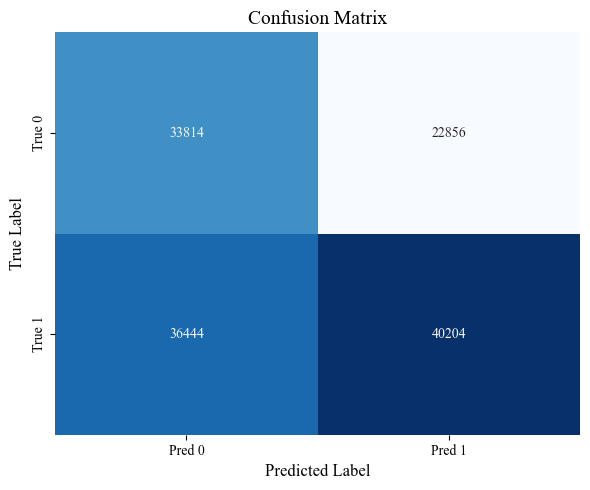

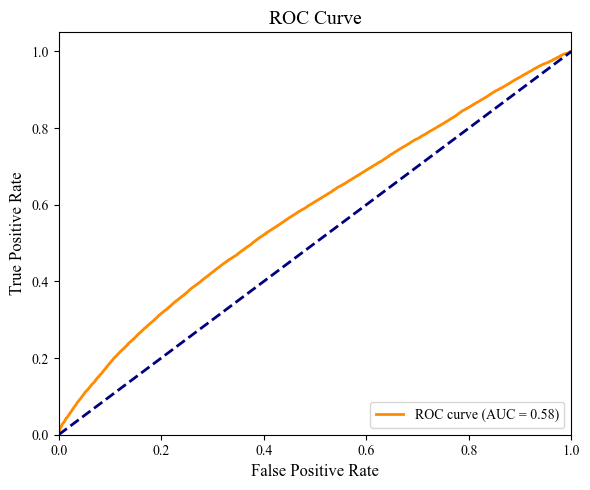

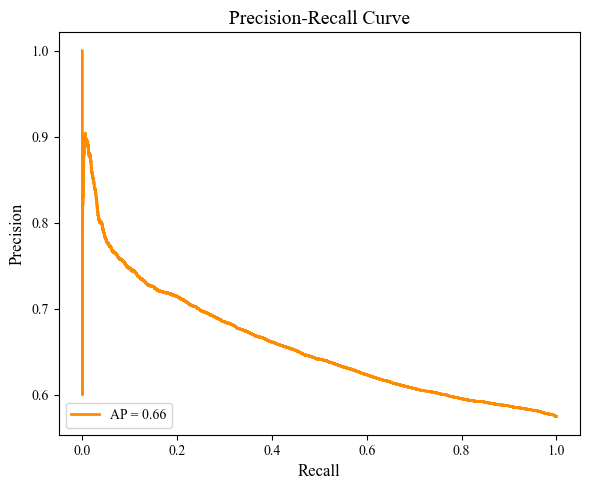

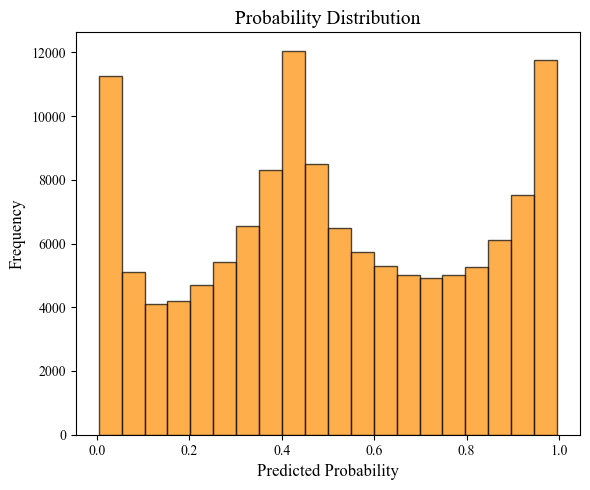

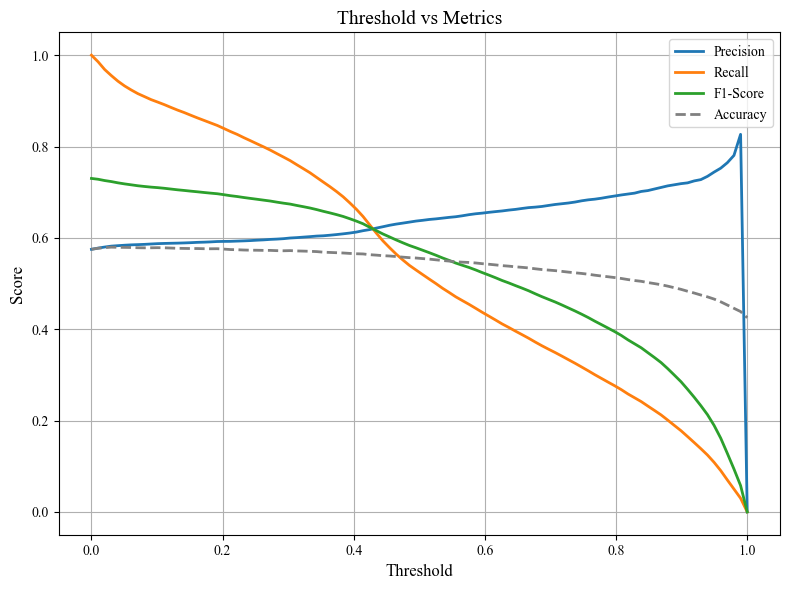

In [16]:
with open(pickle_path, 'rb') as f:
    loaded_lpa_results = pickle.load(f)

# Now use the loaded dictionary for evaluation/plotting
lpa_precision = loaded_lpa_results['precision']
lpa_recall = loaded_lpa_results['recall']
lpa_accuracy = loaded_lpa_results['accuracy']
lpa_all_labels = loaded_lpa_results['labels']
lpa_all_probs = loaded_lpa_results['probs']

# TP, FP, TN, FN

print("Precision =", lpa_precision)
print("Recall =", lpa_recall)
print("Accuracy =", lpa_accuracy)

# Convert probabilities to binary predictions
lpa_pred_labels = [1 if p > args['threshold'] else 0 for p in lpa_all_probs]

# PLOTTING
plot_confusion_matrix(
    lpa_all_labels, 
    lpa_pred_labels, 
    title="Confusion Matrix", 
    save_path=os.path.join(save_path, "confusion_matrix.pdf")
)
plot_roc_curve(
    lpa_all_labels, 
    lpa_all_probs, 
    title="ROC Curve", 
    save_path=os.path.join(save_path, "roc_curve.pdf")
)
plot_precision_recall_curve(
    lpa_all_labels, 
    lpa_all_probs, 
    title="Precision-Recall Curve", 
    save_path=os.path.join(save_path, "precision_recall_curve.pdf")
)
plot_probability_distribution(
    lpa_all_probs, 
    title="Probability Distribution", 
    save_path=os.path.join(save_path, "probability_distribution.pdf")
)
plot_threshold_metrics(
    lpa_all_labels, 
    lpa_all_probs, 
    title="Threshold vs Metrics", 
    save_path=os.path.join(save_path, "threshold_metrics.pdf")
)

### Execution of Table-BERT model

Download checkpoint

(to be executed once in the beginning)

In [8]:
# !wget https://tablefact.s3-us-west-2.amazonaws.com/snapshot.zip
# !unzip snapshot.zip

In [9]:
if RUN_SCRIPT:
    !python run_BERT.py --do_eval --scan horizontal --fact first --load_dir outputs_fact-first_horizontal_snapshot/save_step_12500 --eval_batch_size 16

In [11]:
if not RUN_SCRIPT:
    import run_BERT_adjusted as bert_model

    args = {
        'do_eval': True,
        'scan': 'horizontal',
        'fact': 'first',
        'load_dir': '/Data/tlh45/outputs_fact-first_horizontal_snapshot/save_step_12500',
        'eval_batch_size': 16,
        'do_train': False,
        'threshold': 0.5,
        # Add or override other parameters as needed
    }
    bert_results = bert_model.run_bert_experiment(args)

    if bert_results is not None:
        bert_save_path = os.path.join(this_dir, 'plots', 'bert_table')
        os.makedirs(bert_save_path, exist_ok=True)
        
        bert_pickle_path = os.path.join(bert_save_path, "bert_results.pkl")
        with open(bert_pickle_path, 'wb') as f:
            pickle.dump(bert_results, f)

01/05/2025 17:49:15 - INFO - run_BERT_adjusted -   Running BERT with provided dictionary arguments:
01/05/2025 17:49:15 - INFO - run_BERT_adjusted -   Device: cuda, n_gpu: 1
01/05/2025 17:49:15 - INFO - run_BERT_adjusted -   Datasets are loaded from ../processed_datasets/tsv_data_horizontal
Outputs will be saved to outputs_fact-first_horizontal


{'do_eval': True,
 'do_train': False,
 'eval_batch_size': 16,
 'fact': 'first',
 'load_dir': '/Data/tlh45/outputs_fact-first_horizontal_snapshot/save_step_12500',
 'scan': 'horizontal',
 'threshold': 0.5}


01/05/2025 17:49:23 - INFO - run_BERT_adjusted -   ***** Running evaluation *****
01/05/2025 17:49:23 - INFO - run_BERT_adjusted -     Num examples = 12791
01/05/2025 17:49:23 - INFO - run_BERT_adjusted -     Batch size = 16
Evaluating: 100%|██████████| 800/800 [02:58<00:00,  4.48it/s]


Evaluation results: {'acc': 0.6574935501524509, 'f1': 0.6933575978161965, 'acc_and_f1': 0.6754255739843238, 'eval_loss': 0.5892192220129072}
True Positives: 4953
True Negatives: 3457
False Positives: 2857
False Negatives: 1524
Precision: 0.6341869398207426
Recall: 0.7647058823529411
Accuracy: 0.6574935501524509


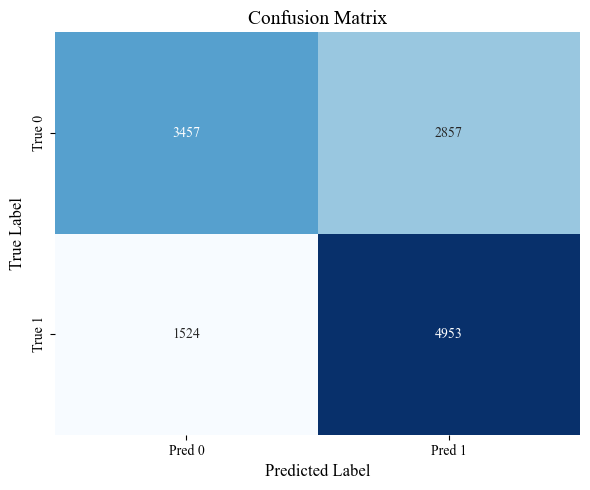

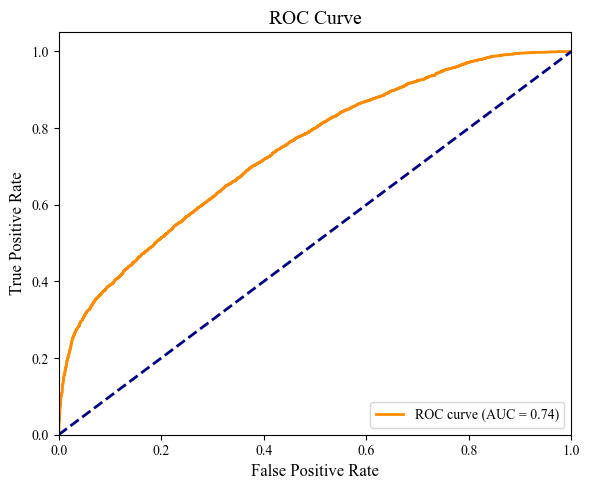

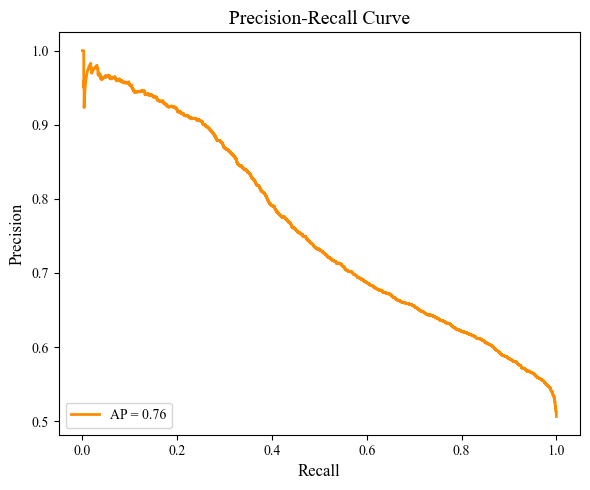

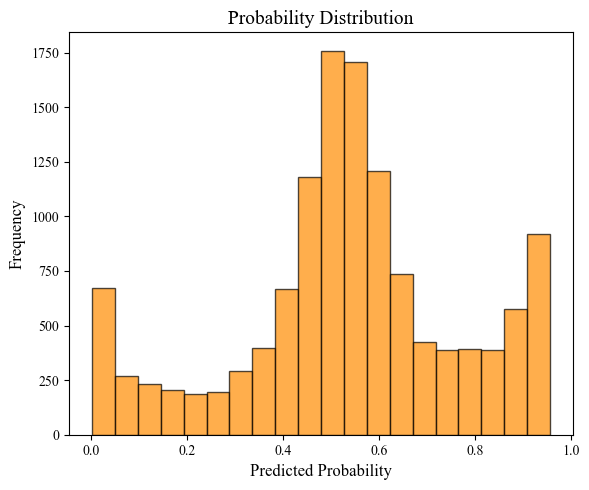

Calculating metrics for thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control

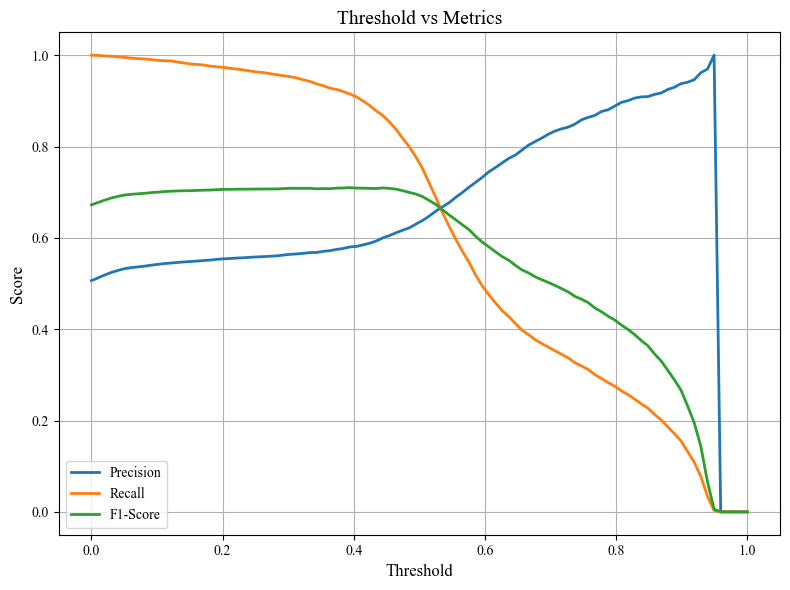

In [13]:
with open(bert_pickle_path, 'rb') as f:
    bert_results = pickle.load(f)

print("Evaluation results:", bert_results['eval_results'])
bert_all_labels = bert_results['labels']
bert_all_probs = bert_results['probs']  # For binary classification
bert_preds = bert_results['preds']

tp, tn, fp, fn = 0, 0, 0, 0
for i in range(len(bert_all_labels)):
    if bert_all_labels[i] == 1 and bert_preds[i] == 1:
        tp += 1
    elif bert_all_labels[i] == 0 and bert_preds[i] == 0:
        tn += 1
    elif bert_all_labels[i] == 0 and bert_preds[i] == 1:
        fp += 1
    elif bert_all_labels[i] == 1 and bert_preds[i] == 0:
        fn += 1

print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

# Precision, Recall, Accuracy
precision = tp / (tp + fp)
recall = tp / (tp + fn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# PLOTTING
# Convert probabilities to binary predictions
bert_pred_labels = [1 if p > args['threshold'] else 0 for p in bert_all_probs]

save_path = os.path.join(this_dir, 'plots', 'bert_table')
plot_confusion_matrix(bert_all_labels, bert_pred_labels, title="Confusion Matrix", save_path=os.path.join(save_path, "confusion_matrix.pdf"))
plot_roc_curve(bert_all_labels, bert_all_probs, title="ROC Curve", save_path=os.path.join(save_path, "roc_curve.pdf"))
plot_precision_recall_curve(bert_all_labels, bert_all_probs, title="Precision-Recall Curve", save_path=os.path.join(save_path, "precision_recall_curve.pdf"))
plot_probability_distribution(bert_all_probs, title="Probability Distribution", save_path=os.path.join(save_path, "probability_distribution.pdf"))
plot_threshold_metrics(bert_all_labels, bert_all_probs, title="Threshold vs Metrics", save_path=os.path.join(save_path, "threshold_metrics.pdf"))

## TAPEX-model

https://github.com/huggingface/transformers/tree/main/examples/research_projects/tapex

In [5]:
# %cd ~/Desktop/GitHubProjects/table-fact-checking-project/TAPEX/
%cd ~/table-fact-checking-project/TAPEX/

/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/TAPEX


/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [16]:

if RUN_SCRIPT:
  !python run_tabfact_with_tapex.py config.json

01/05/2025 11:20:12 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
01/05/2025 11:20:12 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False

In [7]:
from run_tabfact_with_tapex_adjusted import run_tabfact_experiment
import os

args = {
    "do_eval": True,
    "model_name_or_path": "microsoft/tapex-base-finetuned-tabfact",
    "output_dir": "tabfact_tapex_base_eval",
    "per_device_eval_batch_size": 12,
    "eval_accumulation_steps": 6,
    "cache_dir": "/Data/tlh45",
    "threshold": 0.5,
    "local_rank": -1
}

results = run_tabfact_experiment(args)

if results is not None:
    print("Evaluation results:", results["eval_results"])
    tabfact_labels = results["labels"]  # ground-truth labels
    tabfact_probs = results["probs"]    # predicted probability of label=1
    tabfact_preds = results["preds"]    # predicted labels (0 or 1)

    threshold = args["threshold"]
    pred_labels = [1 if p > threshold else 0 for p in tabfact_probs]

    save_path = os.path.join(os.getcwd(), "plots", "tapex")
    os.makedirs(save_path, exist_ok=True)

    plot_confusion_matrix(tabfact_labels, pred_labels, title="Confusion Matrix",
                          save_path=os.path.join(save_path, "confusion_matrix.pdf"))
    plot_roc_curve(tabfact_labels, tabfact_probs, title="ROC Curve",
                   save_path=os.path.join(save_path, "roc_curve.pdf"))
    plot_precision_recall_curve(tabfact_labels, tabfact_probs, title="Precision-Recall Curve",
                                save_path=os.path.join(save_path, "precision_recall_curve.pdf"))
    plot_probability_distribution(tabfact_probs, title="Probability Distribution",
                                  save_path=os.path.join(save_path, "probability_distribution.pdf"))
    plot_threshold_metrics(tabfact_labels, tabfact_probs, title="Threshold vs Metrics",
                           save_path=os.path.join(save_path, "threshold_metrics.pdf"))

01/04/2025 10:55:01 - WARNING - run_tabfact_with_tapex_adjusted - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: True, 16-bits training: False


[WARNING|configuration_utils.py:246] 2025-01-04 10:55:03,392 >> You passed along `num_labels=3` with an incompatible id to label map: {'0': 'Refused', '1': 'Entailed'}. The number of labels wil be overwritten to 2.
/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/TAPEX/run_tabfact_with_tapex_adjusted.py:430: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


: 

## PASTA

https://github.com/ruc-datalab/PASTA?tab=readme-ov-file

In [5]:
# %cd ~/Desktop/GitHubProjects/table-fact-checking/PASTA/
%cd ~/table-fact-checking-project/PASTA/

/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/PASTA


/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/users/eleves-a/2024/tim-luka.horstmann.m2/miniconda/envs/.conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
if RUN_SCRIPT:
    !python src/run_finetune.py src/scripts/train_tabfact.json

/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/PASTA utils/dataset.py
/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/PASTA
DataArguments(tokenizer_path='/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/PASTA/pretrained_models/pasta', cache_file='/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/PASTA/data_cache/tabfact', dataset_path='/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/original_repo', dataset_name='tabfact')
/users/eleves-a/2024/tim-luka.horstmann.m2/table-fact-checking-project/PASTA/src/utils/TabFV_model.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fut

### Compare multiple models

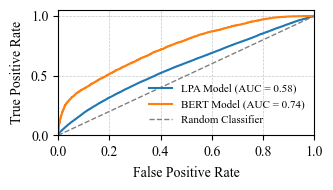

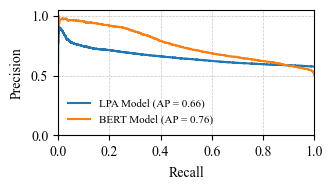

In [28]:
save_path = os.path.join(this_dir, 'plots')

# For ROC:
models_data_roc = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_roc_curves(models_data_roc, title="ROC Curve Comparison", save_path=os.path.join(save_path, "roc_curve_comparison.pdf"))

# For PR:
models_data_pr = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_pr_curves(models_data_pr, title="Precision-Recall Comparison", save_path=os.path.join(save_path, "precision_recall_comparison.pdf"))


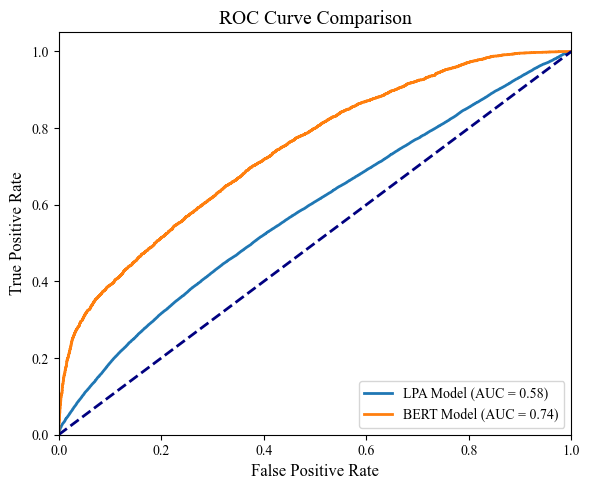

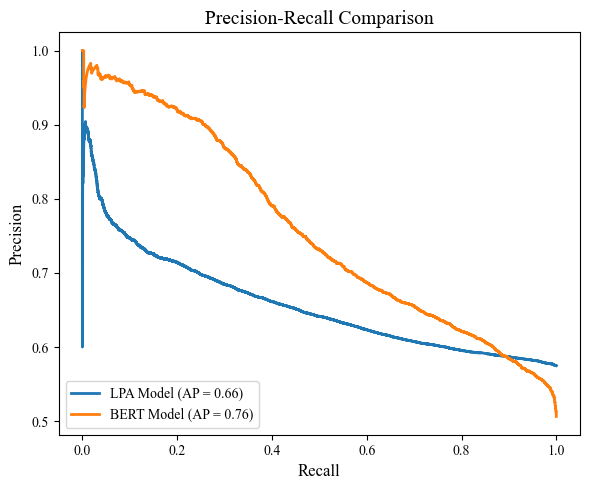

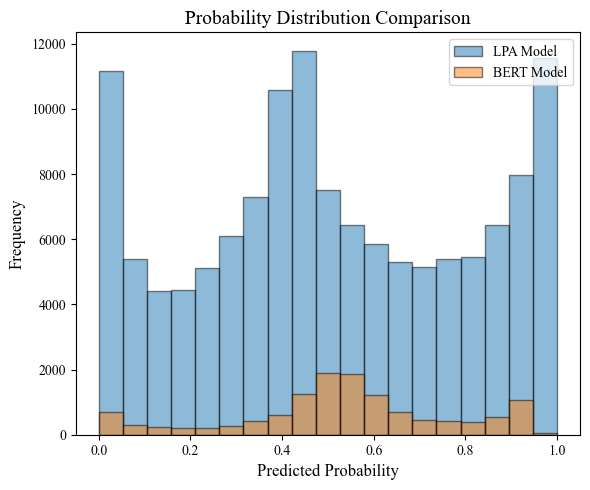

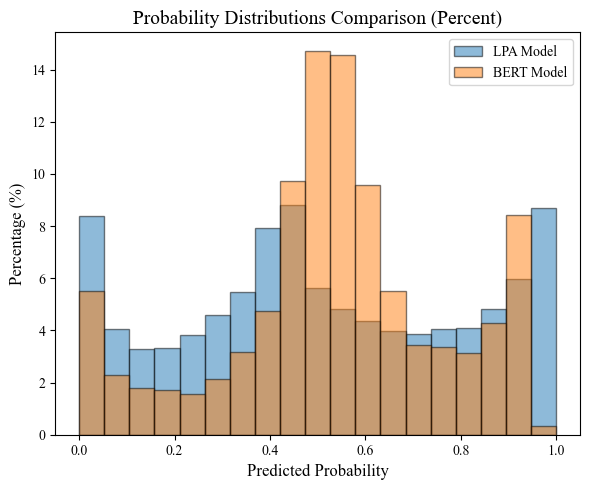

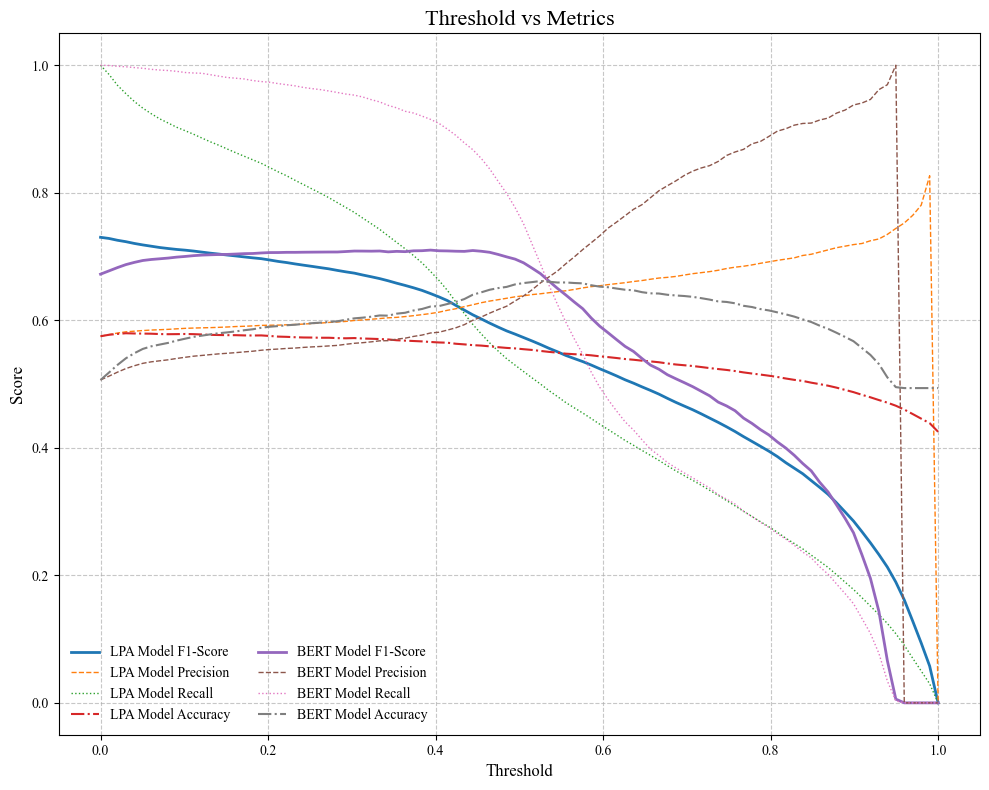

In [18]:
save_path = os.path.join(this_dir, 'plots')

# For ROC:
models_data_roc = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_roc_curves(models_data_roc, title="ROC Curve Comparison", save_path=os.path.join(save_path, "roc_curve_comparison.pdf"))

# For PR:
models_data_pr = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_pr_curves(models_data_pr, title="Precision-Recall Comparison", save_path=os.path.join(save_path, "precision_recall_comparison.pdf"))

# For probability distribution (overlay):
models_data_dist = [
    {"name": "LPA Model", "probs": lpa_all_probs},
    {"name": "BERT Model", "probs": bert_all_probs}
]
plot_multi_probability_distributions(models_data_dist, title="Probability Distribution Comparison", save_path=os.path.join(save_path, "probability_distribution_comparison.pdf"))
plot_multi_probability_distributions_percent(models_data_dist, title="Probability Distributions Comparison (Percent)", save_path=os.path.join(save_path, "probability_distribution_comparison_percent.pdf"))

# For threshold metrics:
models_data_thr = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_threshold_metrics(models_data_thr, title="Threshold vs Metrics", save_path=os.path.join(save_path, "threshold_metrics_comparison.pdf"))